# Morphing Emojis

In [1]:
from controllable_nca.experiments.morphing_image.trainer import MorphingImageNCATrainer
from controllable_nca.experiments.morphing_image.emoji_dataset import EmojiDataset
from controllable_nca.nca import ControllableNCA

import torch

In [2]:
dataset = EmojiDataset(image_size=64)

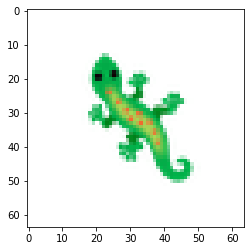

In [3]:
dataset.visualize(0)

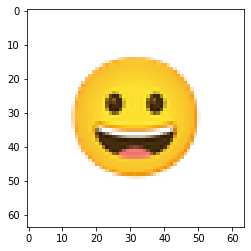

In [4]:
dataset.visualize(1)

### Make NCA

In [5]:
NUM_HIDDEN_CHANNELS = 32

nca =  ControllableNCA(num_goals=dataset.num_goals(), target_shape=dataset.target_size(), living_channel_dim=3, num_hidden_channels=NUM_HIDDEN_CHANNELS, cell_fire_rate=0.8)

In [6]:
device = torch.device('cuda')
nca = nca.to(device)
dataset.to(device)

In [7]:
trainer = MorphingImageNCATrainer(nca, dataset, nca_steps=[48, 64], lr=2e-3, num_damaged=0, damage_radius=3, device=device, pool_size=256)

Writing to tensorboard_logs/2022-02-20 01:05:33.592684


In [8]:
trainer.train(batch_size=8, epochs=100000)

loss:0.06874437630176544--log10loss:-1.1627628239123533--perception_net.weight_g


KeyboardInterrupt: 

In [10]:
from controllable_nca.experiments.morphing_image.visualizer import MorphingImageVisualizer

In [11]:
nca.load("saved_models/morphing_50k.pt")

In [12]:
viz = MorphingImageVisualizer(trainer, 64)

In [13]:
viz.visualize()

Canvas(height=320, width=320)